In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import defaultdict
import random
from sklearn.preprocessing import StandardScaler

In [24]:
from LoadData import SceneDataset
from Models import ShallowCNN, ImprovedCNN, AlexNetTransfer, AlexNetFeatureExtractor, DAG_SVM
from ModelUtilities import train_model, evaluate_model, extract_features
from Utilities import plot_training_history, plot_confusion_matrix

In [3]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

Different type of normalization

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data transforms
# Basic transform for Task 1 (anisotropic rescaling)
basic_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Anisotropic rescaling
    transforms.Grayscale(num_output_channels=1),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img)).unsqueeze(0).float())
])

# Augmented transform for Task 2
augmented_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),  # Left-right reflection
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img)).unsqueeze(0).float())
])


imagenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cpu


# SHALLOW CNN NETWORK: 1st EXPERIMENT

In [26]:
train_dataset = SceneDataset('data/train', transform=basic_transform)
test_dataset = SceneDataset('data/test', transform=basic_transform)

In [27]:
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch [1/40] - Train Loss: 2.7084, Train Acc: 5.73% - Val Loss: 2.7075, Val Acc: 6.67%
Epoch [2/40] - Train Loss: 2.7081, Train Acc: 7.61% - Val Loss: 2.7076, Val Acc: 9.33%
Epoch [3/40] - Train Loss: 2.7078, Train Acc: 8.24% - Val Loss: 2.7072, Val Acc: 8.89%
Epoch [4/40] - Train Loss: 2.7072, Train Acc: 10.67% - Val Loss: 2.7058, Val Acc: 8.44%
Epoch [5/40] - Train Loss: 2.7058, Train Acc: 9.02% - Val Loss: 2.7038, Val Acc: 7.56%
Epoch [6/40] - Train Loss: 2.6996, Train Acc: 9.65% - Val Loss: 2.6956, Val Acc: 12.89%
Epoch [7/40] - Train Loss: 2.6842, Train Acc: 11.06% - Val Loss: 2.6919, Val Acc: 7.56%
Epoch [8/40] - Train Loss: 2.6555, Train Acc: 11.61% - Val Loss: 2.6426, Val Acc: 15.56%
Epoch [9/40] - Train Loss: 2.6212, Train Acc: 14.90% - Val Loss: 2.6815, Val Acc: 11.56%
Epoch [10/40] - Train Loss: 2.5773, Train Acc: 15.14% - Val Loss: 2.9202, Val Acc: 14.22%
Epoch [11/40] - Train Loss: 2.5603, Train Acc: 16.24% - Val Loss: 2.6737, Val Acc: 11.56%
Epoch [12/40] - Train Loss: 2.

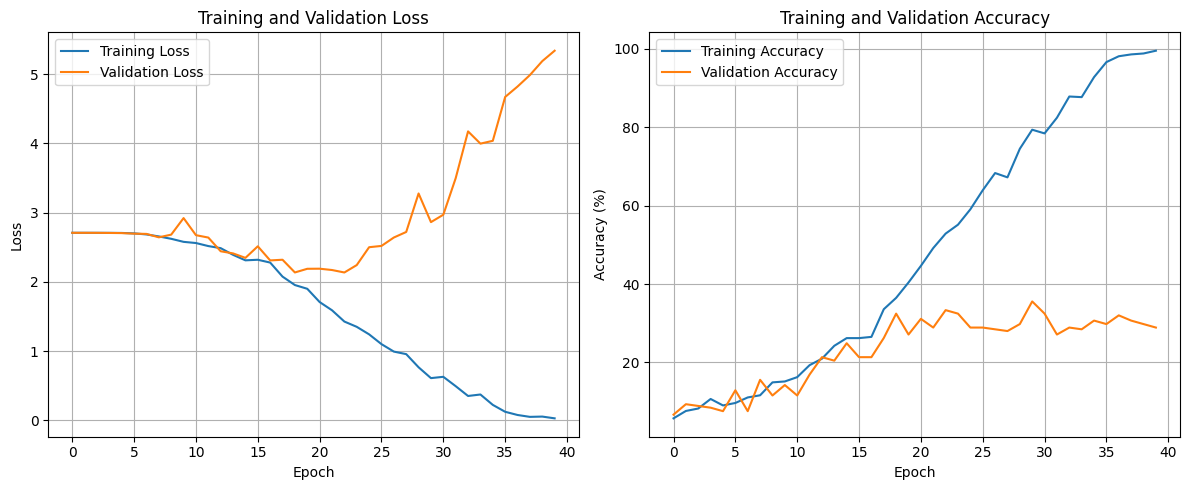

In [28]:
shallow_model = ShallowCNN(num_classes=15)
history = train_model(shallow_model, train_loader, val_loader, num_epochs=40, learning_rate=1e-2, 
                device='cpu', patience=10, lr_min=5e-3)
plot_training_history(history)

In [29]:
accuracy_shallow, cm_shallow, all_predictions_shallow, all_labels_shallow = evaluate_model(shallow_model, test_loader, device)

In [30]:
accuracy_shallow

0.34606365159128977

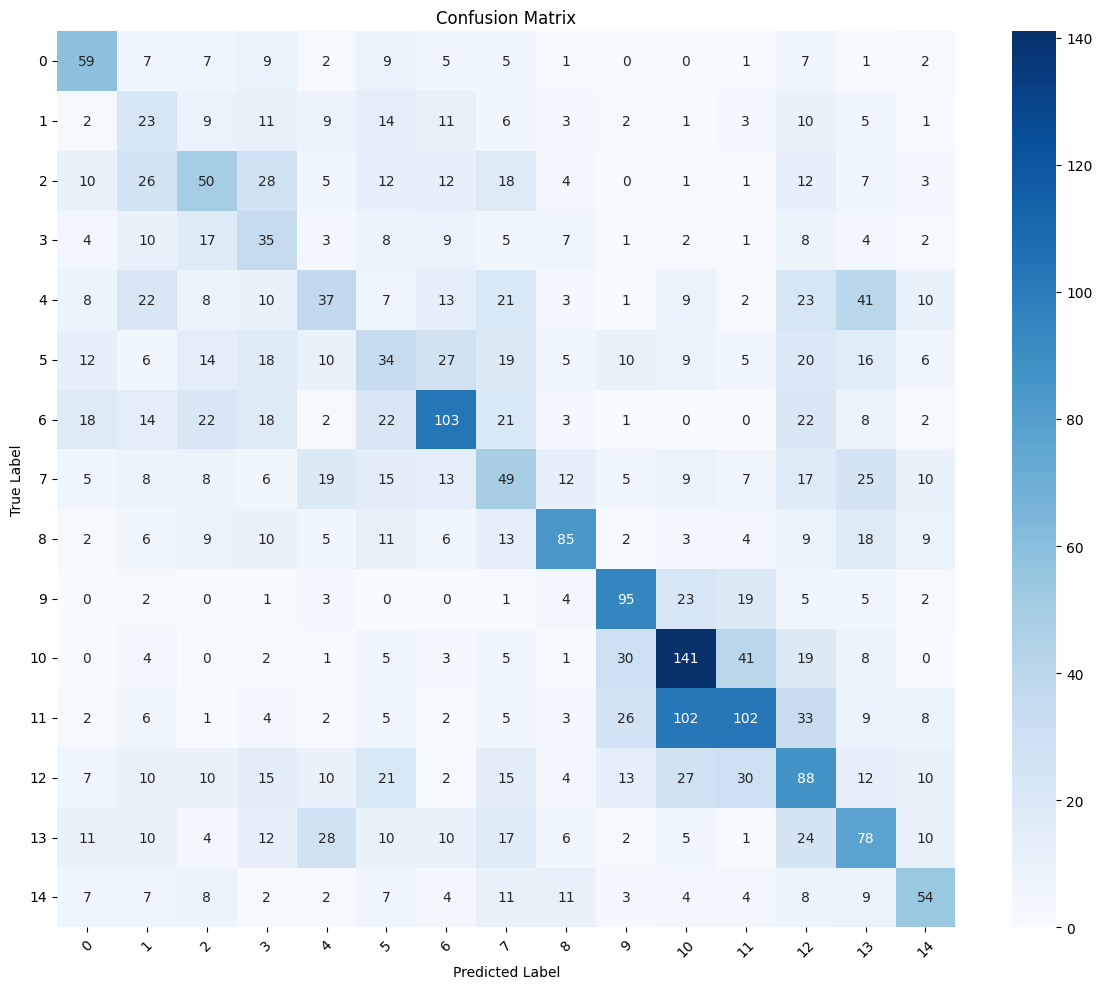

In [31]:
plot_confusion_matrix(cm_shallow, np.unique(np.array(all_labels_shallow)))

# IMPROVED CNN NETWORK: 2nd EXPERIMENT

In [34]:
train_dataset_improved = SceneDataset('data/train', transform=augmented_transform)
test_dataset_improved = SceneDataset('data/test', transform=augmented_transform)

In [35]:
train_size_improved = int(0.85 * len(train_dataset_improved))
val_size_improved = len(train_dataset_improved) - train_size_improved
train_subset_improved, val_subset_improved = random_split(train_dataset_improved, [train_size_improved, val_size_improved])

# Create data loaders
train_loader_improved = DataLoader(train_subset_improved, batch_size=32, shuffle=True)
val_loader_improved = DataLoader(val_subset_improved, batch_size=32, shuffle=False)
test_loader_improved = DataLoader(test_dataset_improved, batch_size=32, shuffle=False)

Epoch [1/40] - Train Loss: 2.8041, Train Acc: 12.94% - Val Loss: 2.5878, Val Acc: 16.89%
Epoch [2/40] - Train Loss: 2.5143, Train Acc: 18.90% - Val Loss: 2.4975, Val Acc: 23.11%
Epoch [3/40] - Train Loss: 2.4247, Train Acc: 23.06% - Val Loss: 2.4727, Val Acc: 27.11%
Epoch [4/40] - Train Loss: 2.3288, Train Acc: 25.49% - Val Loss: 2.3352, Val Acc: 29.33%
Epoch [5/40] - Train Loss: 2.2526, Train Acc: 28.86% - Val Loss: 2.4137, Val Acc: 24.89%
Epoch [6/40] - Train Loss: 2.1493, Train Acc: 30.43% - Val Loss: 2.4061, Val Acc: 28.44%
Epoch [7/40] - Train Loss: 2.1224, Train Acc: 32.78% - Val Loss: 2.4427, Val Acc: 32.00%
Epoch [8/40] - Train Loss: 2.0598, Train Acc: 35.45% - Val Loss: 2.3705, Val Acc: 30.22%
Epoch [9/40] - Train Loss: 2.0157, Train Acc: 34.90% - Val Loss: 3.1258, Val Acc: 16.89%
Epoch [10/40] - Train Loss: 1.9450, Train Acc: 39.84% - Val Loss: 2.5376, Val Acc: 28.89%
Epoch [11/40] - Train Loss: 1.8937, Train Acc: 37.65% - Val Loss: 2.3865, Val Acc: 31.11%
Epoch [12/40] - Tra

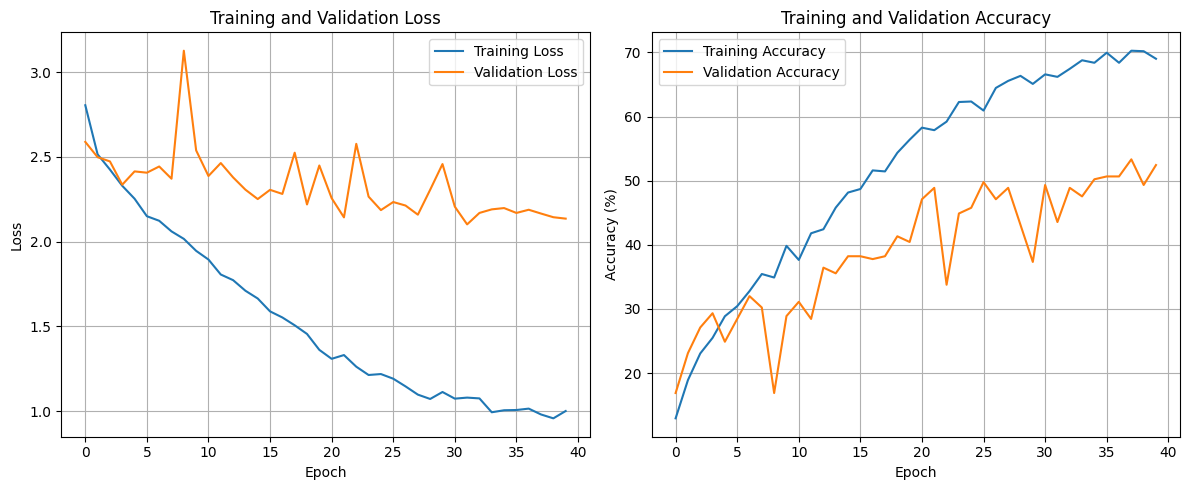

In [36]:
improved_model = ImprovedCNN(num_classes=15)
history = train_model(improved_model, train_loader_improved, val_loader_improved, num_epochs=40, learning_rate=5e-3, 
                device='cpu', patience=10, lr_min=5e-4)
plot_training_history(history)

In [37]:
accuracy_improved, cm_improved, all_predictions_improved, all_labels_improved = evaluate_model(improved_model, test_loader_improved, device)

In [38]:
accuracy_improved

0.5480737018425461

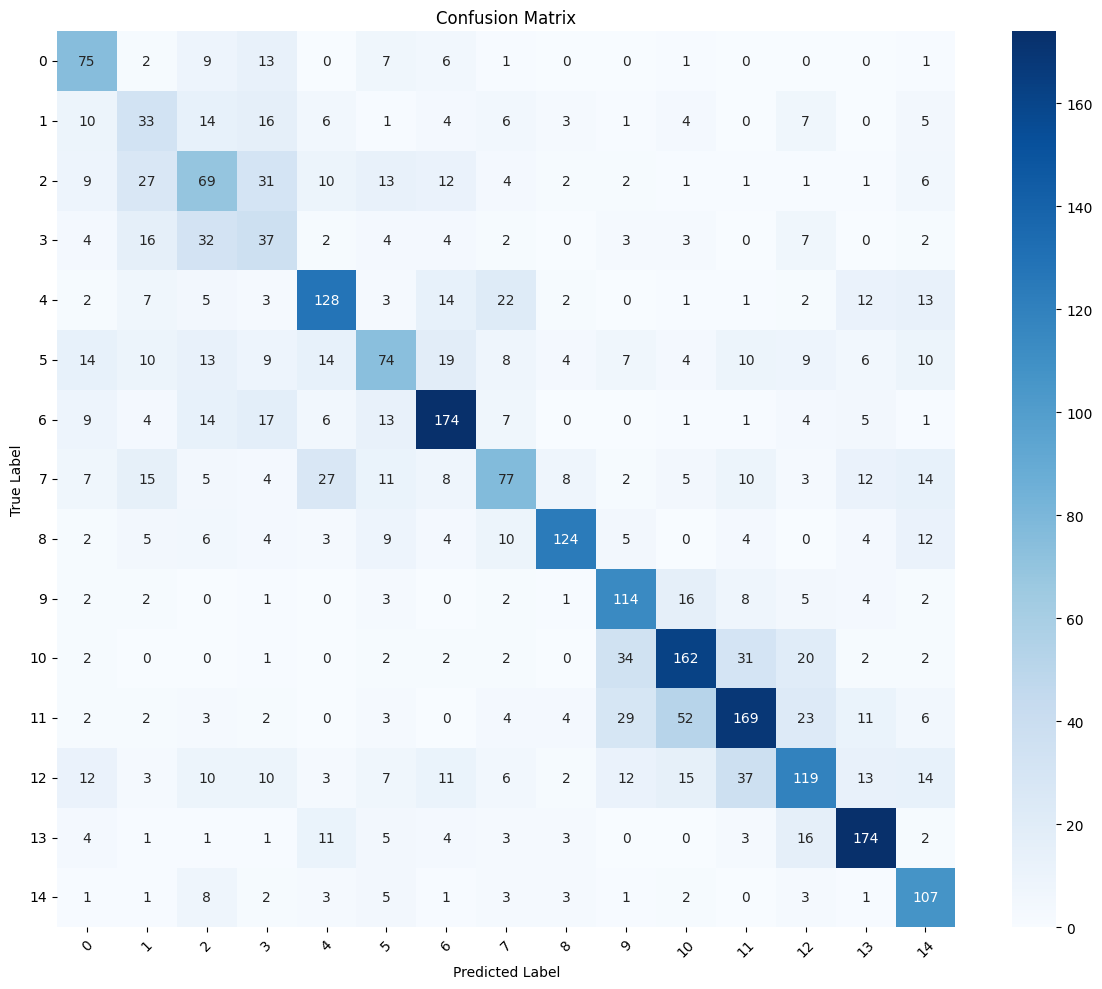

In [39]:
plot_confusion_matrix(cm_improved, np.unique(np.array(all_labels_improved)))

# FINE-TUNED ALEXNET: 3rd EXPERIMENT

In [18]:
train_dataset_imn = SceneDataset('data/train', transform=imagenet_transform)
test_dataset_imn  = SceneDataset('data/test', transform=imagenet_transform)

In [19]:
train_size_imn = int(0.85 * len(train_dataset_imn))
val_size_imn = len(train_dataset_imn) - train_size_imn
train_subset_imn, val_subset_imn = random_split(train_dataset_imn, [train_size_imn, val_size_imn])

# Create data loaders
train_loader_imn = DataLoader(train_subset_imn, batch_size=32, shuffle=True)
val_loader_imn = DataLoader(val_subset_imn, batch_size=32, shuffle=False)
test_loader_imn = DataLoader(test_dataset_imn, batch_size=32, shuffle=False)

In [20]:
# Initialize model
model_imn = AlexNetTransfer(num_classes=15, freeze_features=True)
model_imn = model_imn.to(device)

c:\Users\matte\myenv_RL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matte\myenv_RL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40] - Train Loss: 1.3134, Train Acc: 60.39% - Val Loss: 0.7052, Val Acc: 81.33%
Epoch [2/40] - Train Loss: 0.5974, Train Acc: 84.16% - Val Loss: 0.5013, Val Acc: 85.33%
Epoch [3/40] - Train Loss: 0.4579, Train Acc: 85.57% - Val Loss: 0.4157, Val Acc: 85.78%
Epoch [4/40] - Train Loss: 0.4002, Train Acc: 88.24% - Val Loss: 0.3877, Val Acc: 84.00%
Epoch [5/40] - Train Loss: 0.3503, Train Acc: 90.35% - Val Loss: 0.3719, Val Acc: 87.56%
Epoch [6/40] - Train Loss: 0.3235, Train Acc: 91.37% - Val Loss: 0.3493, Val Acc: 88.89%
Epoch [7/40] - Train Loss: 0.2959, Train Acc: 91.14% - Val Loss: 0.3557, Val Acc: 87.56%
Epoch [8/40] - Train Loss: 0.2718, Train Acc: 93.02% - Val Loss: 0.3257, Val Acc: 88.44%
Epoch [9/40] - Train Loss: 0.2431, Train Acc: 93.88% - Val Loss: 0.3385, Val Acc: 87.11%
Epoch [10/40] - Train Loss: 0.2376, Train Acc: 94.59% - Val Loss: 0.3044, Val Acc: 88.00%
Epoch [11/40] - Train Loss: 0.2231, Train Acc: 94.27% - Val Loss: 0.2991, Val Acc: 88.00%
Epoch [12/40] - Tra

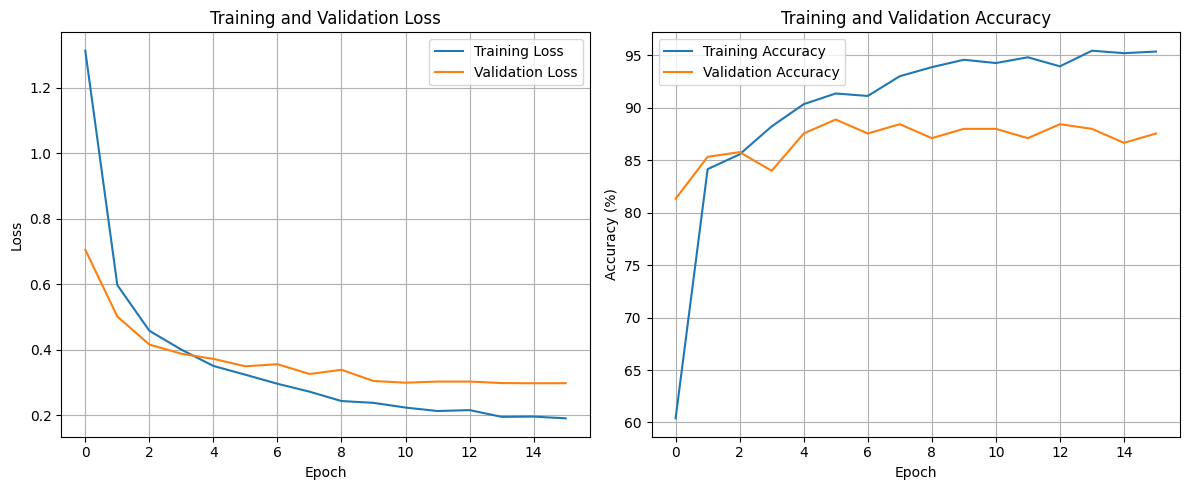

In [21]:
history = train_model(model_imn, train_loader_imn, val_loader_imn, num_epochs=40, learning_rate=5e-3, 
                device='cpu', patience=10, lr_min=5e-4)
plot_training_history(history)

In [22]:
accuracy_imn, cm_imn, all_predictions_imn, all_labels_imn = evaluate_model(model_imn, test_loader_imn, device)

In [23]:
accuracy_imn

0.8680067001675041

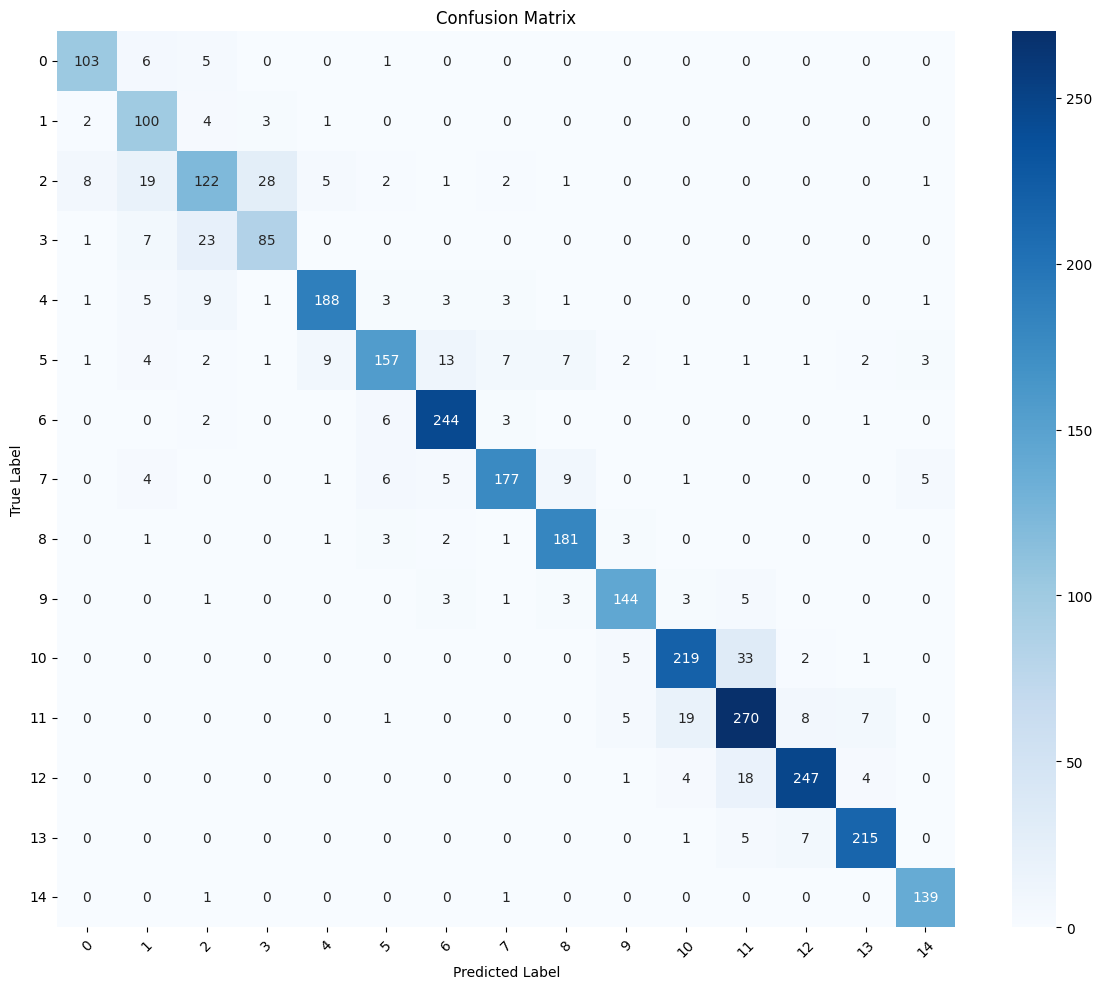

In [24]:
plot_confusion_matrix(cm_imn, np.unique(np.array(all_labels_imn)))

# DAG-SVM ON ALEXNET FEATURES EXTRACTION: 4th EXPERIMENT

In [25]:
feature_extractor = AlexNetFeatureExtractor(layer_name='fc2')  # Using fc2 layer (4096 features)
feature_extractor = feature_extractor.to(device)

c:\Users\matte\myenv_RL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matte\myenv_RL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
train_features, train_labels = extract_features(feature_extractor, train_loader_imn, device)

val_features, val_labels = extract_features(feature_extractor, val_loader_imn, device)

test_features, test_labels = extract_features(feature_extractor, test_loader_imn, device)


Extracting features from 40 batches...
Processed batch 0/40
Extracting features from 8 batches...
Processed batch 0/8
Extracting features from 94 batches...
Processed batch 0/94
Processed batch 50/94


In [27]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

In [29]:
dag_linear = DAG_SVM(kernel='linear')
dag_linear.fit(train_features_scaled, train_labels)

Training 105 binary SVM classifiers...
Training classifier 1/105: Class 0 vs Class 1
Training classifier 2/105: Class 0 vs Class 2
Training classifier 3/105: Class 0 vs Class 3
Training classifier 4/105: Class 0 vs Class 4
Training classifier 5/105: Class 0 vs Class 5
Training classifier 6/105: Class 0 vs Class 6
Training classifier 7/105: Class 0 vs Class 7
Training classifier 8/105: Class 0 vs Class 8
Training classifier 9/105: Class 0 vs Class 9
Training classifier 10/105: Class 0 vs Class 10
Training classifier 11/105: Class 0 vs Class 11
Training classifier 12/105: Class 0 vs Class 12
Training classifier 13/105: Class 0 vs Class 13
Training classifier 14/105: Class 0 vs Class 14
Training classifier 15/105: Class 1 vs Class 2
Training classifier 16/105: Class 1 vs Class 3
Training classifier 17/105: Class 1 vs Class 4
Training classifier 18/105: Class 1 vs Class 5
Training classifier 19/105: Class 1 vs Class 6
Training classifier 20/105: Class 1 vs Class 7
Training classifier 21/10

In [30]:
dag_linear_test_predictions = dag_linear.predict(test_features_scaled)

dag_linear_test_acc = accuracy_score(test_labels, dag_linear_test_predictions)

In [31]:
dag_linear_test_acc

0.861641541038526

In [28]:
dag_svm = DAG_SVM(kernel='rbf')
dag_svm.fit(train_features_scaled, train_labels)

Training 105 binary SVM classifiers...
Training classifier 1/105: Class 0 vs Class 1
Training classifier 2/105: Class 0 vs Class 2
Training classifier 3/105: Class 0 vs Class 3
Training classifier 4/105: Class 0 vs Class 4
Training classifier 5/105: Class 0 vs Class 5
Training classifier 6/105: Class 0 vs Class 6
Training classifier 7/105: Class 0 vs Class 7
Training classifier 8/105: Class 0 vs Class 8
Training classifier 9/105: Class 0 vs Class 9
Training classifier 10/105: Class 0 vs Class 10
Training classifier 11/105: Class 0 vs Class 11
Training classifier 12/105: Class 0 vs Class 12
Training classifier 13/105: Class 0 vs Class 13
Training classifier 14/105: Class 0 vs Class 14
Training classifier 15/105: Class 1 vs Class 2
Training classifier 16/105: Class 1 vs Class 3
Training classifier 17/105: Class 1 vs Class 4
Training classifier 18/105: Class 1 vs Class 5
Training classifier 19/105: Class 1 vs Class 6
Training classifier 20/105: Class 1 vs Class 7
Training classifier 21/10

In [12]:
dag_test_predictions = dag_svm.predict(test_features_scaled)

dag_test_acc = accuracy_score(test_labels, dag_test_predictions)


In [13]:
dag_test_acc

0.8036850921273032